In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

2024-05-23 13:05:07.628278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 13:05:08.740413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-23 13:05:08.740437: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-23 13:05:08.867258: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 13:05:11.210053: W tensorflow/stream_executor/pla

## Carga del conjunto de validación

Se carga el conjunto de validación del dataset mediante ImageDataGenerator

In [5]:
# Configuración del generador para validación (usualmente sin aumentación, solo reescalado)
validation_datagen = ImageDataGenerator(rescale=1./255)
# Creación del generador de validación
validation_generator = validation_datagen.flow_from_directory(
    '../images/test/',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary', # o 'categorical'
    shuffle=True
)


Found 31 images belonging to 2 classes.


In [6]:
# Después de haber creado tu generador
class_indices = validation_generator.class_indices
print("Class indices:", class_indices)

Class indices: {'0': 0, '1': 1}


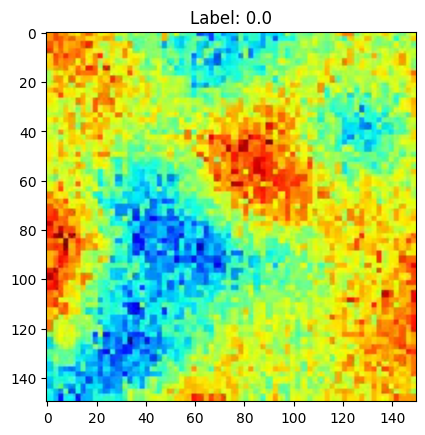

In [7]:
# Obtener el primer lote de imágenes y etiquetas
images, labels = next(validation_generator)

# Extraer la primera imagen y su etiqueta del lote
first_image = images[0]
first_label = labels[0]

# Si necesitas visualizar la imagen, puedes usar matplotlib
import matplotlib.pyplot as plt


plt.imshow(first_image)
plt.title(f'Label: {first_label}')
plt.show()
first_image = np.expand_dims(first_image, axis=0)

## Ejecución de simulaciones Monte Carlo

En el siguiente codigo se cargan las imágnes del conjunto de evaluación y se realizan las simulaciones para Monte Carlo Dropout, los resultados se guardan en un csv diferente para cada modelo

In [9]:
modelos = []
for filename in os.listdir('../models'):
    modelos.append(filename)

In [11]:
# Suponiendo que 'modelo' es tu modelo Keras con MC Dropout configurado para la inferencia
# Y 'data_generator' es tu generador de datos o iterador

n_iteraciones = 2  # Número de pasadas de MC Dropout por imagen


  # Para almacenar los resultados
for name in modelos:
    resultados = []
    model = tf.keras.models.load_model(f'../models/{name}')
    for filename in validation_generator.filenames:
        ruta_imagen = os.path.join(validation_generator.directory, filename)
        imagen = load_img(ruta_imagen, target_size=(150, 150))  # Ajusta el tamaño según tu modelo
        imagen = img_to_array(imagen) / 255.0  # Reescala si tu modelo lo requiere
        imagen = np.expand_dims(imagen, axis=0)  # Ajusta la forma para el modelo

        predicciones = np.array([model(imagen,training = True)[0] for _ in range(n_iteraciones)])

                # Calcular estadísticas
        media = np.mean(predicciones, axis=0)
        std = np.std(predicciones, axis=0)



                # Guardar resultados
        resultados.append({
            'filename': filename,
            'media': media,
            'std': std,

                })
            # Convertir resultados en DataFrame
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(f'../experiments/results/{name}.csv',sep = ';',index = False)

2024-05-19 17:06:59.127028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-19 17:06:59.127079: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-19 17:06:59.127112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2024-05-19 17:06:59.127482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualización de mapas de características

Con el siguiente código se pueden visualziar los mapas de características de la red neuronal

In [ ]:
layer_outputs = [model.layers[0].output]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Obtener los mapas de activación
activations = activation_model.predict(imagen)

# El resultado 'activations' es una lista donde cada elemento corresponde a las activaciones de una capa
first_layer_activations = activations[0]

# Elegir un filtro específico, por ejemplo, el primero
# first_layer_activations tiene una forma de (1, size, size, num_filters)
filter_index = 2  # Cambia este índice para ver diferentes filtros

# Visualizar el mapa de activación del filtro elegido
plt.imshow(first_layer_activations[:, :, filter_index], cmap='viridis')
plt.axis('off')
plt.show()
